<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

# Creacion, entrenamiento y prueba de la red

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

In [ ]:
#----------Paths----------

labels_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/labels.csv'
names_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/names.csv'
images_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/images.npz'

labels_raw = pd.read_csv(labels_path, header = None)
labels_raw = labels_raw.values.tolist()
labels = []
for label in labels_raw:
  labels.append(label[0])

names = pd.read_csv(names_path, header = None)
names = names.values.tolist()

images = np.load(images_path)
images = images['arr_0']

images_list = []
labels_list = []
names_list = []

for i in range(0, 6):
    A = random.randint(0, 2079)
    images_list.append(images[A])
    labels_list.append(labels[A])
    names_list.append(names[A])

for i in range(0,6):
    plt.subplot(2,3, i+1)
    imagen = images_list[i]
    print("Image name: ", names_list[i])
    print("Label: ", labels_list[i])
    plt.imshow(imagen)
plt.show()

In [ ]:
#Preparando la data para cambiar las clases por 1 para positivos y 0 para negativos

binary_labels = []
for label in labels:
  if label == 'Negative':
    binary_labels.append(0)
  else: 
    binary_labels.append(1)

#Division de la data para entrenar y probar la red

#x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2)
x_train, x_test, y_train, y_test = train_test_split(images, binary_labels, test_size = 0.2)

FineSpeckled_CytoplasmicFibrillar


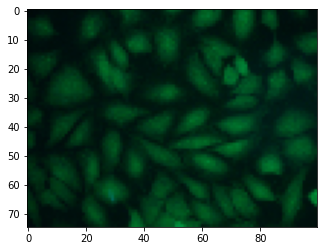

In [26]:
#Clase Dataset Personaliazdo

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label

#Creando Dataloader para los conjuntos de entrenamiento y prueba
       
train_data = CustomImageDataset(x_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)

test_data = CustomImageDataset(x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

images, labels = next(iter(train_dataloader))
plt.imshow(images[0])
print(labels[0])

In [9]:
#Clase Convolutional Nerual Netwokr (CNN)

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # Capa convolucional con 3 canales para las imagenes entrante, 6 canales para la salida y un kernel convolucional cuadrado de 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Capa convolucional con 6 canales para las imagenes entrante, 16 canales para la salida y un kernel convolucional cuadrado de 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Capa lineal (y = Wx + b) con 16*5*5 neuronas de entrada y 120 salidas para cada una
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        # Capa lineal (y = Wx + b) con 120 neuronas de entrada y 84 salidas para cada una
        self.fc2 = nn.Linear(120, 84)
        # Capa lineal (y = Wx + b) con 84 neuronas de entrada y 1 salida para cada una
        self.fc3 = nn.Linear(84, 1)

        #Optimizador
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01, betas=(0.9, 0.99), eps=1e-08)

        #Funcion de perdida
        self.loss_fn = nn.BCELoss()
        if torch.cuda.is_available():
          self.loss_fn = self.loss_fn.cuda()

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoide(self.fc3(x))
        return x

binary_model = CNN()

if torch.cuda.is_available():
    binary_model = binary_model.cuda()
    


CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
  (loss_fn): BCELoss()
)
